In [90]:
import importlib
import model.Portfolio as Portfolio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

importlib.reload(Portfolio)

<module 'model.Portfolio' from '/home/raymond/Desktop/quant/model/Portfolio.py'>

In [91]:
names = ["VUSA", "A35", "S59", "VUSD", "BAB", "IWDA", "Z74", "ES3", "VWRD"]
p = Portfolio.Portfolio()

# Add all assets
for name in names:
    p.addAsset(f"data/{name}.csv", name)

# Convert non SGD assets to SGD
p.addExchangeRate("data/forex/SGDEUR.csv", "EUR", True)
p.addExchangeRate("data/forex/USDSGD.csv", "USD", False)
p.exchangeAdjustment(0, "EUR")
p.exchangeAdjustment(3, "USD")
p.exchangeAdjustment(4, "USD")
p.exchangeAdjustment(5, "USD")
p.exchangeAdjustment(8, "USD")
# p.exchangeAdjustment(9, "USD")

[0.08992020522, 0.2744348384, 0.03070927321, 0.01896821775, 0.06166520726, 0.06204753154, 0.02053451402, 0.3393806347, 0.102339578]


{'valueStart': 100000.0,
 'valueEnd': 136880.8698902693,
 'returns': 1.368808698902693,
 'sharpe': 0.17250148812534735,
 'drawdown': 0.871492505791684,
 'moneydown': 1203.394011582248,
 'maxDrawdown': 12.472099548565895,
 'maxMoneydown': 14646.856656697055}

In [120]:
currentWeight = [
    0.08992020522,
    0.2744348384,
    0.03070927321,
    0.01896821775,
    0.06166520726,
    0.06204753154,
    0.02053451402,
    0.3393806347,
    0.102339578
]

# p.portfolioPerformance(currentWeight)
p.backtest(weights=currentWeight)

[0.08992020522, 0.2744348384, 0.03070927321, 0.01896821775, 0.06166520726, 0.06204753154, 0.02053451402, 0.3393806347, 0.102339578]


{'valueStart': 100000.0,
 'valueEnd': 136880.8698902693,
 'returns': 1.368808698902693,
 'sharpe': 0.17250148812534735,
 'drawdown': 0.871492505791684,
 'moneydown': 1203.394011582248,
 'maxDrawdown': 12.472099548565895,
 'maxMoneydown': 14646.856656697055}

In [64]:
def randomWeight(length):
    w = np.random.random(length)
    w /= np.sum(w)
    return w

In [110]:
%%time

noSimulations = 1000
rf = 0.02
simWeights = []
simRets = []
simVols = []
simSharpes = []

for i in range(noSimulations):
    weights = randomWeight(len(names))
    perf = p.portfolioPerformance(weights, rf=rf)

    simWeights.append(weights)
    simRets.append(perf["returns"])
    simVols.append(perf["variance"])
    simSharpes.append(perf["sharpe"])

CPU times: user 4.28 s, sys: 3.99 ms, total: 4.28 s
Wall time: 4.28 s


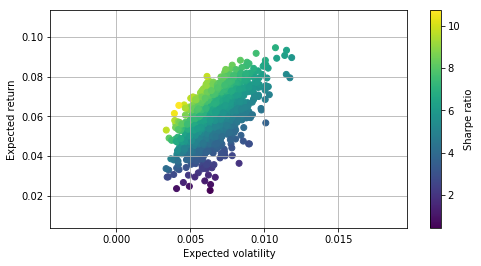

In [66]:
plt.figure(figsize=(8, 4))
plt.scatter(simVols, simRets, c=simSharpes, marker="o")
plt.grid(True)
plt.xlabel("Expected volatility")
plt.ylabel("Expected return")
plt.colorbar(label="Sharpe ratio")
plt.show()

In [67]:
# Get top 10 portfolio with highest sharpe
sortedIndices = np.argsort(simSharpes)[-10:]

results = []
for x in sortedIndices:
    results.append(np.insert(simWeights[x], 0, [simSharpes[x], simRets[x], simVols[x]]))
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + names)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD
0,9.430327,0.064098,0.004676,0.109348,0.209528,0.008040,0.068211,0.217748,0.030931,0.150325,0.030808,0.175060
1,9.575358,0.057925,0.003961,0.211757,0.206125,0.095819,0.041850,0.268974,0.019353,0.002643,0.041166,0.112311
2,9.580994,0.069771,0.005195,0.008693,0.275172,0.014728,0.305598,0.176112,0.040418,0.095357,0.048978,0.034944
3,9.630001,0.069364,0.005126,0.190598,0.210816,0.010537,0.069852,0.172309,0.096057,0.059127,0.101766,0.088938
4,9.737959,0.069083,0.005040,0.009716,0.200863,0.069247,0.075300,0.280669,0.273206,0.003367,0.025914,0.061718
5,9.760821,0.053093,0.003390,0.059581,0.124261,0.065019,0.063512,0.334425,0.070061,0.130749,0.134619,0.017772
6,9.780668,0.080080,0.006143,0.008731,0.085549,0.017565,0.176689,0.343824,0.107458,0.065388,0.030852,0.163944
7,9.956501,0.065745,0.004594,0.094113,0.212036,0.002432,0.025575,0.185792,0.216859,0.102894,0.128654,0.031645
8,10.532933,0.061457,0.003936,0.039840,0.190800,0.083483,0.096597,0.345199,0.107738,0.012516,0.031014,0.092812
9,10.736296,0.065508,0.004239,0.033170,0.156033,0.002731,0.027474,0.270315,0.218319,0.095425,0.162398,0.034134


In [113]:
import scipy.optimize as sco
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

class Optimizer:
    def __init__(self, portfolio):
        self.portfolio = portfolio

    def optimize(self, interval):
        numberOfAssets = len(self.portfolio.assetNames)
        constraints = {"type": "eq", "fun": lambda x: np.sum(abs(x)) - 1}
        bounds = tuple((0, 1) for x in range(numberOfAssets))
        initial = np.array(numberOfAssets * [1.0 / numberOfAssets])
        options = sco.minimize(
            lambda x: -self.portfolio.portfolioPerformance(x, rf=0.02, interval=interval)["sharpe"],
            initial,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )
#         print(options)
        return options["x"]
    
    def kfold(self):
        # Split into 5 sections
        startDate, endDate = p.commonInterval()
        tscv = TimeSeriesSplit(n_splits=5)
        returnsSubsetCommon = self.portfolio.assetReturnsDf.loc[startDate: endDate]
        
        totalWeights = []
        
        for train_index, test_index in tscv.split(returnsSubsetCommon):
            train = self.portfolio.assetReturnsDf.iloc[train_index]
            test = self.portfolio.assetReturnsDf.iloc[test_index]
            # Train on data
            optimiserWeight = self.optimize(interval=(train_index[0], train_index[-1]))
            # Test on test data
            testResult = self.portfolio.portfolioPerformance(optimiserWeight, interval=(test_index[0], test_index[-1]))
            totalWeights.append(optimiserWeight)
#             print(testResult)
        return totalWeights

In [114]:
o = Optimizer(p)
w = o.kfold()

In [117]:
w
print(p.backtest(weights=w[0]))
print(p.backtest(weights=w[1]))
print(p.backtest(weights=w[2]))
print(p.backtest(weights=w[3]))
print(p.backtest(weights=w[4]))

[4.85243216e-01 3.22936616e-02 1.05366932e-01 3.28507241e-13
 3.01225677e-01 2.06980998e-13 2.85596343e-02 4.73108793e-02
 3.76001612e-13]
{'valueStart': 100000.0, 'valueEnd': 153018.76108287854, 'returns': 1.5301876108287853, 'sharpe': 0.2804678344248736, 'drawdown': 0.0, 'moneydown': 0.0, 'maxDrawdown': 11.412023461730566, 'maxMoneydown': 17346.184595591913}
[3.36170783e-01 8.71881537e-02 3.21025550e-13 0.00000000e+00
 4.36175614e-01 0.00000000e+00 1.04003789e-01 3.64616603e-02
 3.10331605e-13]
{'valueStart': 100000.0, 'valueEnd': 156056.86528007925, 'returns': 1.5605686528007925, 'sharpe': 0.29884667725845626, 'drawdown': 0.0, 'moneydown': 0.0, 'maxDrawdown': 5.946947466005969, 'maxMoneydown': 8862.752144665166}
[1.91426992e-01 1.27563787e-01 0.00000000e+00 1.78362163e-02
 5.71910741e-01 5.43954259e-14 9.12622638e-02 0.00000000e+00
 0.00000000e+00]
{'valueStart': 100000.0, 'valueEnd': 150008.80305799973, 'returns': 1.5000880305799973, 'sharpe': 0.26118745923872333, 'drawdown': 0.0, 

In [121]:
df = pd.DataFrame(w)
# print(df)

meanWeight = np.mean(df)
np.std(df)

# print(list(meanWeight))

# p.portfolioPerformance(list(meanWeight))
# print(p.backtest(weights=list(meanWeight)))
list(meanWeight)

[0.27313647525475526,
 0.10411962949647757,
 0.023301092502984587,
 0.003567243269516992,
 0.45090198663425385,
 0.03909438178591511,
 0.05174074967548845,
 0.05413844138063697,
 1.3726664322886128e-13]

In [29]:
%%time
o = Optimizer(p)
optimiserWeight = o.optimize()

     fun: -16.825623170149214
     jac: array([10.320086  , 10.32507968, 29.0620153 , 11.3801825 , 10.32740974,
       10.3241365 , 10.32181072, 10.32520843, 18.95101333, 10.31759048])
 message: 'Optimization terminated successfully.'
    nfev: 206
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.1685908 , 0.16565275, 0.        , 0.        , 0.50039283,
       0.04323066, 0.01559638, 0.09344825, 0.        , 0.01308833])
CPU times: user 754 ms, sys: 0 ns, total: 754 ms
Wall time: 751 ms


In [30]:
p.portfolioPerformance(optimiserWeight)

{'returns': 0.07176797140197455,
 'variance': 0.003076734268827409,
 'sharpe': 23.326022051727737}

In [32]:
dict(zip(names, optimiserWeight))

{'VUSA': 0.16859079866869434,
 'A35': 0.1656527473150624,
 'S59': 0.0,
 'VUSD': 0.0,
 'BAB': 0.5003928298601455,
 'IWDA': 0.04323066028400976,
 'Z74': 0.015596381524557066,
 'ES3': 0.09344824927743772,
 'VWRD': 0.0,
 'BTC': 0.013088333075637518}

## Next Step

- Timeseries K-fold validation when generating weights
    - Monte carlo on K-1 segments of data
    - Test result on 1 segment of data
- Genetics algorithm
- Add backtest capabilities
    - Report over the entire period
    - Custom period

## Even More Advanced Shits

- Selective optimisation for time period (ie interest rate hike, financial crisis, etc)